<a href="https://colab.research.google.com/github/ljnmuyrong/Final-Examination/blob/main/Final_Exam_Model_Deployment_in_the_Cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Final Exam: Model Deployment in the Cloud

Muyrong

Caberte



In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.layers import Flatten, Dense, Activation, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from keras import models, regularizers, optimizers
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras import layers, models
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Adamax
from keras.models import model_from_json
from PIL import Image
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint
from keras.applications import DenseNet121
from keras.applications.densenet import DenseNet121, preprocess_input

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
dataset_dir = '/content/drive/MyDrive/Data'
data_paths = []
labels = []

main_dirs = os.listdir(dataset_dir)
for folder_name in main_dirs:
    folder_path = os.path.join(dataset_dir, folder_name)
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data_paths.append(file_path)
        labels.append(folder_name)

In [8]:
batch_size = 16
image_size = (150, 150)
num_channels = 3
image_shape = (image_size[0], image_size[1], num_channels)

data_dirs = pd.Series(data_paths, name='data_dir')
classes = pd.Series(labels, name='class')
dataframe = pd.concat([data_dirs, classes], axis=1)

def preprocess_image(img):
    return img

In [9]:
train_df, val_test_df = train_test_split(dataframe, train_size=0.8, shuffle=True, random_state=123)
val_df, test_df = train_test_split(val_test_df, train_size=0.5, shuffle=True, random_state=123)

datagen = ImageDataGenerator(preprocessing_function=preprocess_image, rescale=1.0/255)
train_generator = datagen.flow_from_dataframe(train_df, x_col='data_dir', y_col='class',
                                              target_size=image_size, class_mode='categorical',
                                              color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_generator = datagen.flow_from_dataframe(val_df, x_col='data_dir', y_col='class',
                                              target_size=image_size, class_mode='categorical',
                                              color_mode='rgb', shuffle=True, batch_size=batch_size)
test_generator = datagen.flow_from_dataframe(test_df, x_col='data_dir', y_col='class',
                                             target_size=image_size, class_mode='categorical',
                                             color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 371 validated image filenames belonging to 4 classes.
Found 44 validated image filenames belonging to 4 classes.
Found 46 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 13 invalid image filename(s) in x_col="data_dir". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="data_dir". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="data_dir". These filename(s) will be ignored.
  warnings.warn(


In [10]:
class_indices = train_generator.class_indices
print(class_indices)

step_size_train = train_generator.n // train_generator.batch_size
step_size_valid = valid_generator.n // valid_generator.batch_size

print(dataframe)

{'Dinosaur': 0, 'Flag': 1, 'airplane': 2, 'puppy': 3}
                                              data_dir  class
0         /content/drive/MyDrive/Data/puppy/vector.svg  puppy
1        /content/drive/MyDrive/Data/puppy/vector3.svg  puppy
2        /content/drive/MyDrive/Data/puppy/vector2.svg  puppy
3        /content/drive/MyDrive/Data/puppy/vector5.svg  puppy
4        /content/drive/MyDrive/Data/puppy/vector4.svg  puppy
..                                                 ...    ...
475       /content/drive/MyDrive/Data/Flag/AN-flag.jpg   Flag
476  /content/drive/MyDrive/Data/Flag/ejo7fczqfrllp...   Flag
477  /content/drive/MyDrive/Data/Flag/bandiera-ital...   Flag
478  /content/drive/MyDrive/Data/Flag/Dansk2520flag...   Flag
479  /content/drive/MyDrive/Data/Flag/flag_10701087...   Flag

[480 rows x 2 columns]


In [11]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3) ,
    classes=4
)

29084464/29084464 [==============================] - 0s 0us/step


In [12]:
for layer in base_model.layers:
    layer.trainable = False
model = Sequential()
model.add(base_model)
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))

model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [13]:
checkpoint_path = "/content/drive/MyDrive/Data/bestmodel.hdf5.h5"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Convert labels to numpy arrays
train_labels_array = np.array(train_generator.labels)
valid_labels_array = np.array(valid_generator.labels)

# Check label encoding
print("Shape of train labels:", train_labels_array.shape)
print("Shape of validation labels:", valid_labels_array.shape)

# Check model output configuration
model.summary()


Shape of train labels: (371,)
Shape of validation labels: (44,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 1024)              16778240  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                          

In [16]:
# Check number of unique classes in your dataset
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

x_batch, y_batch = next(train_generator)
print("Shape of batch labels:", y_batch.shape)

print("Example labels:", y_batch[:5])


Number of classes: 4
Shape of batch labels: (16, 4)
Example labels: [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/10
 6/23 [======>.......................] - ETA: 34s - loss: 9.0483 - accuracy: 0.6145

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


23/23 [==============================] - ETA: 0s - loss: 6.3743 - accuracy: 0.5859
Epoch 1: val_accuracy improved from -inf to 0.68750, saving model to /content/drive/MyDrive/Data/bestmodel.hdf5.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 79s 3s/step - loss: 6.3743 - accuracy: 0.5859 - val_loss: 1.0516 - val_accuracy: 0.6875
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 0.7839 - accuracy: 0.8028
Epoch 2: val_accuracy improved from 0.68750 to 1.00000, saving model to /content/drive/MyDrive/Data/bestmodel.hdf5.h5
23/23 [==============================] - 40s 2s/step - loss: 0.7839 - accuracy: 0.8028 - val_loss: 0.0703 - val_accuracy: 1.0000
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.9042
Epoch 3: val_accuracy did not improve from 1.00000
23/23 [==============================] - 43s 2s/step - loss: 0.2356 - accuracy: 0.9042 - val_loss: 0.2414 - val_accuracy: 0.9375
Epoch 4/10
23/23 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.9324
Epoch 4: val_accuracy did not improve from 1.00000
23/23 [==============================] - 35s 2s/step - loss: 0.2726 - accuracy: 0.9324 - val_loss: 0.0226 - val

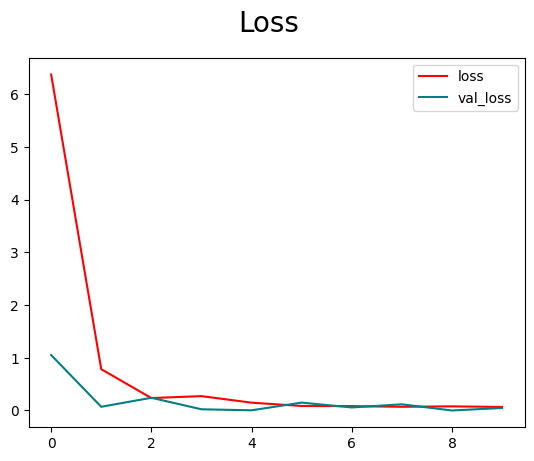

In [18]:
fig = plt.figure()
plt.plot(history.history['loss'], color='red', label='loss')
plt.plot(history.history['val_loss'], color='teal', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

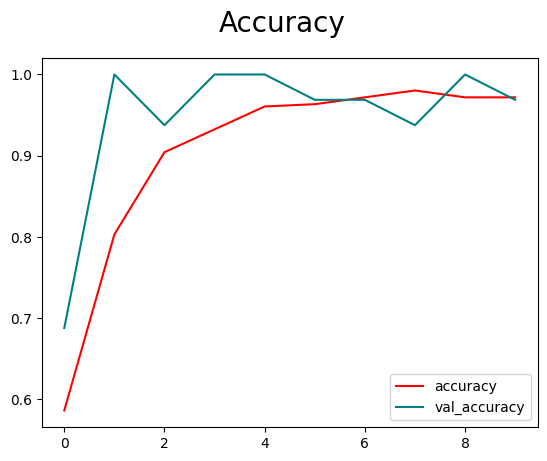

In [19]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='red', label='accuracy')
plt.plot(history.history['val_accuracy'], color='teal', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()